In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Dropout,MaxPool2D,Flatten,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

2022-02-05 03:07:45.954686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

# TPUStrategy for distributed training
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else: # default strategy that works on CPU and single GPU
  strategy = tf.distribute.get_strategy()

In [3]:
train_data=pd.read_csv(r"../input/fashionmnist/fashion-mnist_train.csv")
test_data=pd.read_csv(r"../input/fashionmnist/fashion-mnist_test.csv")

In [4]:
print(train_data.shape)
print(test_data.shape)
print(type(train_data))
print(type(test_data))

(60000, 785)
(10000, 785)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
X_train=train_data.drop(['label'],axis=1)
y_train=train_data['label']

X_test=test_data.drop(['label'],axis=1)
y_test=test_data['label']

In [6]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)

X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4   0
   0   0   0   0  62  61  21  29  23  51 136  61   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  88 201 228 225 255 115  62
 137 255 235 222 255 135   0   0   0   0   0   0   0   0   0   0   0   0
   0  47 252 234 238 224 215 215 229 108 180 207 214 224 231 249 254  45
   0   0   0   0   0   0   0   0   1   0   0 214 222 210 213 224 225 217
 220 254 233 219 221 217 223 221 240 254   0   0   1   0   0   0   1   0
   0   0 128 237 207 224 224 207 216 214 210 208 211 221 208 219 213 226
 211 237 150   0   0   0   0   0   0   2   0   0 237 222 215 207 210 212
 213 206 214 213 214 213 210 215 214 206 199 218 25

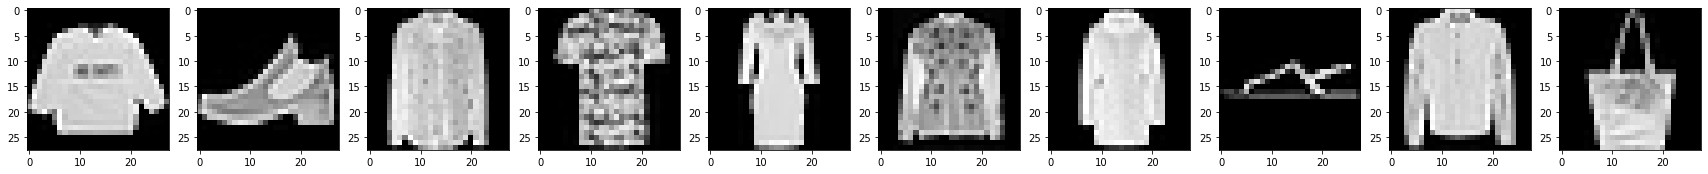

[2 9 6 0 3 4 4 5 4 8]


In [7]:
train_images=X_train.reshape(60000,28,28,1)
test_images=X_test.reshape(10000,28,28,1)

for i in range(10):
    plt.figure(num=1,figsize=(30,30))
    plt.subplot(2,10,i+1)
    plt.imshow(train_images[i],'gray')
plt.show()

print(y_train[0:10])


In [8]:
train_images=train_images/255
test_images=test_images/255

train_labels=to_categorical(y_train,10)
test_labels=to_categorical(y_test,10)


In [9]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28, 1)
(60000, 10)


In [10]:
model=Sequential()

model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(10,activation='softmax'))


2022-02-05 03:07:57.714736: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-05 03:07:57.718213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-05 03:07:57.843132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 03:07:57.843795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-05 03:07:57.843853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 03:07:57.872320: I tensorflow/stream_executor/platform/def

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
early_stop=EarlyStopping(monitor='val_loss',patience=10)

In [12]:
history=model.fit(train_images,train_labels,epochs=50,batch_size=128,validation_split=0.2,callbacks=[early_stop])

2022-02-05 03:08:00.184663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-05 03:08:00.196592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


Epoch 1/50


2022-02-05 03:08:01.223481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-05 03:08:02.091916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-05 03:08:02.103544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


375/375 [==============================] - 11s 9ms/step - loss: 0.8400 - acc: 0.6937 - val_loss: 0.3514 - val_acc: 0.8772
Epoch 2/50
375/375 [==============================] - 3s 7ms/step - loss: 0.3557 - acc: 0.8688 - val_loss: 0.2830 - val_acc: 0.8984
Epoch 3/50
375/375 [==============================] - 3s 7ms/step - loss: 0.2916 - acc: 0.8926 - val_loss: 0.2482 - val_acc: 0.9114
Epoch 4/50
375/375 [==============================] - 3s 7ms/step - loss: 0.2504 - acc: 0.9076 - val_loss: 0.2334 - val_acc: 0.9146
Epoch 5/50
375/375 [==============================] - 3s 7ms/step - loss: 0.2258 - acc: 0.9149 - val_loss: 0.2167 - val_acc: 0.9227
Epoch 6/50
375/375 [==============================] - 3s 7ms/step - loss: 0.2137 - acc: 0.9200 - val_loss: 0.2122 - val_acc: 0.9242
Epoch 7/50
375/375 [==============================] - 3s 7ms/step - loss: 0.1988 - acc: 0.9266 - val_loss: 0.2002 - val_acc: 0.9280
Epoch 8/50
375/375 [==============================] - 3s 7ms/step - loss: 0.1815 - acc

(array([0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 , 0.975]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

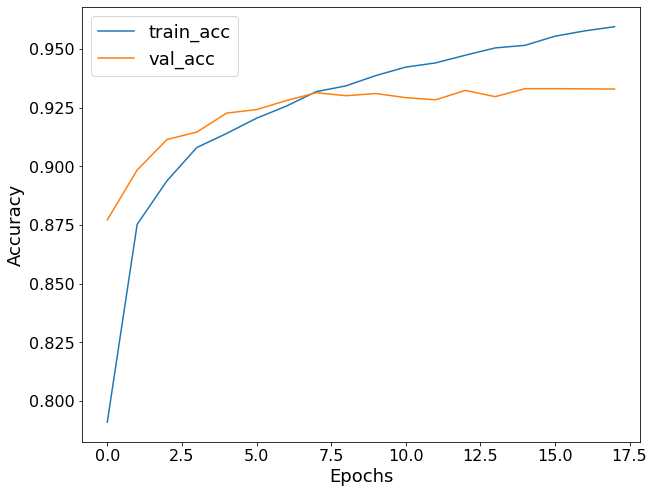

In [13]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'],label='train_acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend(fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

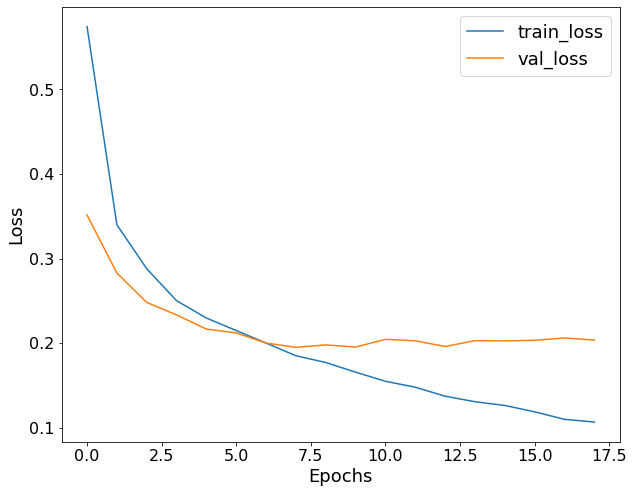

In [14]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend(fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [15]:
test_loss,test_acc=model.evaluate(test_images,test_labels)
print('loss:{:.3f}\nacc: {:.3f}'.format(test_loss,test_acc))

test_ans=np.argmax(test_labels[10:20],axis=1)
print(test_ans)

test_predictions=model.predict(test_images[10:20])
test_predictions=np.argmax(test_predictions,axis=1)

print(test_predictions)

313/313 [==============================] - 1s 2ms/step - loss: 0.1889 - acc: 0.9356
loss:0.189
acc: 0.936
[3 4 4 6 8 5 6 3 6 4]
[3 4 4 6 8 5 6 3 6 4]
